# TP Digit recognition

Authors: William Liaw.

## Importing libraries

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [2]:
keras.utils.set_random_seed(0)

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


## Importing data

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

## Preliminary data analysis

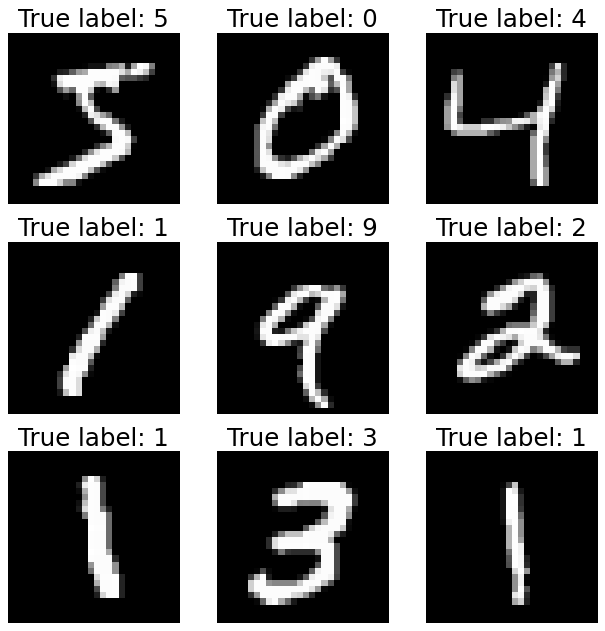

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8), dpi=80)
axs = np.ravel(axs)

for index, ax in enumerate(axs):
    ax.imshow(x_train[index], cmap="gray")
    ax.set_title(f"True label: {y_train[index]}", fontsize=22)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_test.shape

(10000, 28, 28)

In [8]:
validation_samples = 10000
img_shape = x_train.shape[1:]

x_train = x_train.reshape(-1, img_shape[0]*img_shape[1])
x_test = x_test.reshape(-1, img_shape[0]*img_shape[1])

# Reserve samples for validation
x_validation = x_train[-validation_samples:]
y_validation = y_train[-validation_samples:]
x_train = x_train[:-validation_samples]
y_train = y_train[:-validation_samples]

## 4. Model

In [9]:
def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation=None, name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

    return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


### Question 4.1.

In [12]:
print(f"Numeber of optimization variables: {model.count_params()}")

Numeber of optimization variables: 26506


## 5. Stochastic gradient descent

### Question 5.1.

In [13]:
def stochastic_gradient_descent(
    model,
    epochs,
    batch_size,
    x_train,
    y_train,
    x_validation,
    y_validation,
    train_step,
    test_step,
    train_accuracy_metric,
    validation_accuracy_metric,
    log_batches,
):
    # Prepare the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(
        batch_size
    )

    # Prepare the validation dataset
    validation_dataset = tf.data.Dataset.from_tensor_slices(
        (x_validation, y_validation)
    )
    validation_dataset = validation_dataset.batch(batch_size)

    for epoch in range(epochs):
        loss_history = []
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.perf_counter()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train)

            # Log every log_batches batches
            if step % log_batches == 0:
                logits = model(x_train, training=False)
                loss_history.append(loss_function(y_train, logits))

                print(f"Training loss (for one batch) at step {step}: {loss_value:.4f}")
                print(f"Seen so far: {(step + 1) * batch_size} samples")


        # Display metrics at the end of each epoch
        train_acc = train_accuracy_metric.result()
        print(f"Training accuracy over epoch: {float(train_acc):.4f}")

        # Reset training metrics at the end of each epoch
        train_accuracy_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_validation, y_batch_validation in validation_dataset:
            test_step(x_batch_validation, y_batch_validation)

        end_time = time.perf_counter()
        validation_accuracy = validation_accuracy_metric.result()
        validation_accuracy_metric.reset_states()

        print(f"Validation accuracy: {float(validation_accuracy):.4f}")
        print(f"Time taken: {end_time - start_time:.2f}s")

    return loss_history

### Question 5.2.

In [14]:
model = build_model()

In [15]:
batch_size = 1
epochs = 1
validation_samples = 10000
log_batches = 5000

In [16]:
# Instantiate an optimizer.
learning_rate = 1 / np.sqrt(
    epochs * x_train.shape[0] // batch_size
)
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Instantiate a loss function.
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_accuracy_metric = keras.metrics.SparseCategoricalAccuracy()
validation_accuracy_metric = keras.metrics.SparseCategoricalAccuracy()

In [17]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_function(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy_metric.update_state(y, logits)
    return loss_value


@tf.function
def test_step(x, y):
    validation_logits = model(x, training=False)
    validation_accuracy_metric.update_state(y, validation_logits)

In [18]:
loss_history = stochastic_gradient_descent(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    x_train=x_train,
    y_train=y_train,
    x_validation=x_validation,
    y_validation=y_validation,
    train_step=train_step,
    test_step=test_step,
    train_accuracy_metric=train_accuracy_metric,
    validation_accuracy_metric=validation_accuracy_metric,
    log_batches=log_batches,
)


Start of epoch 0
Training loss (for one batch) at step 0: 154.5033
Seen so far: 1 samples
Training loss (for one batch) at step 5000: 2.4696
Seen so far: 5001 samples
Training loss (for one batch) at step 10000: 2.3966
Seen so far: 10001 samples
Training loss (for one batch) at step 15000: 2.3174
Seen so far: 15001 samples
Training loss (for one batch) at step 20000: 2.3455
Seen so far: 20001 samples
Training loss (for one batch) at step 25000: 2.2245
Seen so far: 25001 samples
Training loss (for one batch) at step 30000: 2.3916
Seen so far: 30001 samples
Training loss (for one batch) at step 35000: 2.4189
Seen so far: 35001 samples
Training loss (for one batch) at step 40000: 2.2541
Seen so far: 40001 samples
Training loss (for one batch) at step 45000: 2.3438
Seen so far: 45001 samples
Training accuracy over epoch: 0.1113
Validation accuracy: 0.1064
Time taken: 43.99s


### Question 5.2.

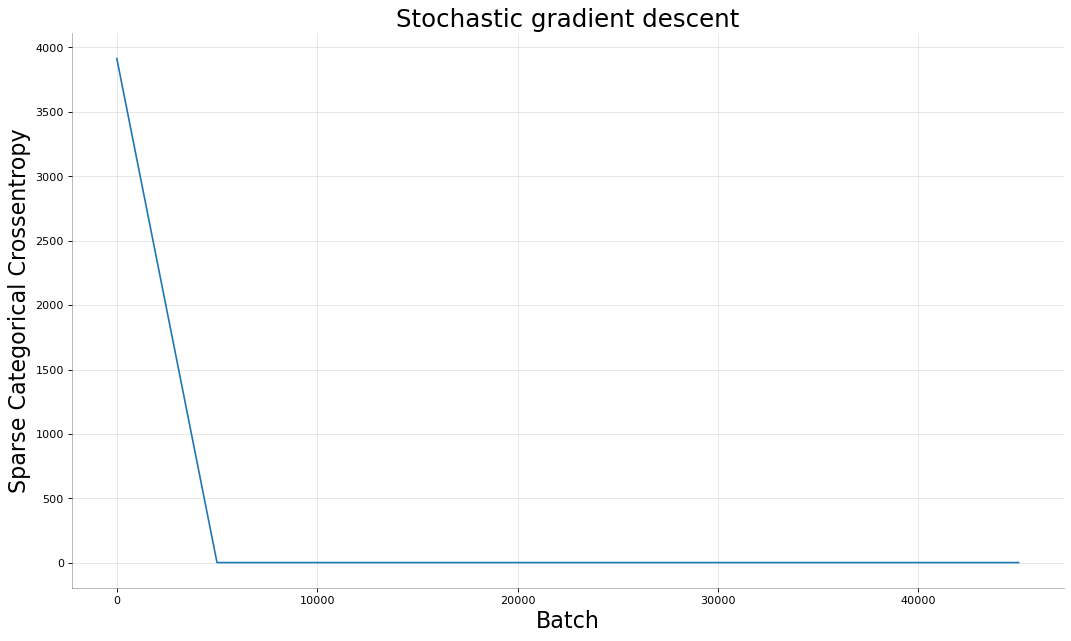

In [19]:
plt.figure(figsize=(16, 9), dpi=80)
plt.plot(
    np.arange(x_train.shape[0], step=log_batches),
    loss_history,
)
plt.title("Stochastic gradient descent", fontsize=22)
plt.xlabel("Batch", fontsize=20)
plt.ylabel("Sparse Categorical Crossentropy", fontsize=20)


plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)
plt.grid(alpha=0.3)
plt.show()

## 6. Empirical risk minimization

### Question 6.1.

In [20]:
model = build_model()

In [21]:
batch_size = 64
epochs = 10
log_batches = 100

In [22]:
# Instantiate an optimizer.
learning_rate = 1 / np.sqrt(
    epochs * x_train.shape[0] // batch_size
)
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

# Instantiate a loss function.
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_accuracy_metric = keras.metrics.SparseCategoricalAccuracy()
validation_accuracy_metric = keras.metrics.SparseCategoricalAccuracy()

In [23]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_function(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy_metric.update_state(y, logits)
    return loss_value


@tf.function
def test_step(x, y):
    validation_logits = model(x, training=False)
    validation_accuracy_metric.update_state(y, validation_logits)

In [24]:
loss_history = stochastic_gradient_descent(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    x_train=x_train,
    y_train=y_train,
    x_validation=x_validation,
    y_validation=y_validation,
    train_step=train_step,
    test_step=test_step,
    train_accuracy_metric=train_accuracy_metric,
    validation_accuracy_metric=validation_accuracy_metric,
    log_batches=log_batches,
)


Start of epoch 0
Training loss (for one batch) at step 0: 129.2923
Seen so far: 64 samples
Training loss (for one batch) at step 100: 1.9245
Seen so far: 6464 samples
Training loss (for one batch) at step 200: 2.6073
Seen so far: 12864 samples
Training loss (for one batch) at step 300: 1.4319
Seen so far: 19264 samples
Training loss (for one batch) at step 400: 1.2466
Seen so far: 25664 samples
Training loss (for one batch) at step 500: 1.4365
Seen so far: 32064 samples
Training loss (for one batch) at step 600: 1.2466
Seen so far: 38464 samples
Training loss (for one batch) at step 700: 1.4575
Seen so far: 44864 samples
Training accuracy over epoch: 0.4757
Validation accuracy: 0.5665
Time taken: 2.03s

Start of epoch 1
Training loss (for one batch) at step 0: 1.2706
Seen so far: 64 samples
Training loss (for one batch) at step 100: 1.0977
Seen so far: 6464 samples
Training loss (for one batch) at step 200: 1.5411
Seen so far: 12864 samples
Training loss (for one batch) at step 300: 1

### Question 6.2.

Batch size is a hyperparameter in stochastic gradient descent (SGD) and other optimization algorithms that determines the number of training samples to work through before updating the internal model parameters. The choice of batch size can significantly impact the convergence speed, memory requirements, and computational efficiency of the learning process. Here are some advantages of using batches over a batch size of 1 (which is effectively pure stochastic gradient descent):

1. **Efficiency**: Using larger batch sizes can take better advantage of parallelism in modern hardware like GPUs and TPUs. Computationally, processing multiple data points simultaneously can be more efficient than processing them one by one. This leads to faster training times, especially for deep learning models trained on large datasets.

2. **Stability**: Larger batch sizes often lead to more stable convergence because they provide a smoother gradient estimate. The noise inherent in the gradient estimates from individual samples is reduced when averaged over a batch, which can lead to more consistent updates to the model parameters and faster convergence to a local minimum.

3. **Memory efficiency**: Working with larger batches can be more memory-efficient compared to processing individual samples one at a time. This is because the computation can be optimized to take advantage of efficient memory access patterns when processing batches of data.

4. **Regularization**: Using batch sizes larger than 1 can have a regularizing effect on the model, similar to adding noise to the parameter updates. This regularization can help prevent overfitting and improve the generalization performance of the model.

5. **Noise reduction**: While stochastic gradient descent (batch size of 1) can provide very noisy estimates of the gradient, using larger batch sizes can reduce this noise, leading to smoother updates and potentially faster convergence.

However, using larger batch sizes also comes with its own set of challenges, such as increased memory requirements, potential for getting stuck in poor local minima, and sensitivity to the learning rate. The choice of batch size often involves a trade-off between efficiency and convergence speed, and it may need to be tuned along with other hyperparameters during the model training process.

### Question 6.3.

Already added since the beginning.